In [1]:
from rikiddo_combo import RikiddoComboScoringRule
import numpy as np
import random
import pandas as pd
from itertools import permutations
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cobyla
import math

In [2]:
poss_outcomes = ['A', 'B', 'C']
#iterate over 1 and combos of 2 assets
possible_combos = list(permutations(poss_outcomes))
combo_assets = []
for i in possible_combos:
    value = ''
    for j in range(len(i)):
        value += str(i[j])
    combo_assets += [value]

In [3]:
n = 500
outcome = 0.001
amount = np.random.random([n]) * 500. 
outcomes = []
values = list(range(10))
for i in range(n):
    outcomes += random.choices(list(range(len(combo_assets))))
    
operation = []
for i in range(n):
    for j in range(0,3):
        operation += [j]

outcomes = np.array(outcomes)
operation = np.array(operation)

In [4]:
class LS_LMSRMarket(object):
    def __init__(self, possible_outcomes, n_params, initial_liquidity, vig=0.1, init=1.0, market='LS_LMSR', b=None):
        """
        Parameters
        ----------
        possible_outcomes   list
                            list of all possible outcomes of the market
                            
        n_params            list
                            A list that consists on the 3 parameters that influnces the variable fee
                            
        initial_liquidity   int
                            Amount of initial liquidity that is provided for each one of the assets
                                    
        vig                 float
                            parameter of the `alpha` variable used to calculate the `b` variable.
                            Corresponds to the market "vig" value
                
        init                float
                            The initial subsidies of the market, spread equally in this algorithm on all the outcomes.
        
        
                            
        """
        
        def combo_assets_maker(assets):
            possible_combos = list(permutations(assets))
            combo_assets = []
            for i in possible_combos:
                value = ''
                for j in range(len(i)):
                    value += str(i[j])
                combo_assets += [value]

            return combo_assets
            
        self.possible_outcomes = combo_assets_maker(possible_outcomes)
        
        self.initial_liquidity = initial_liquidity
        
        self.init = init
        self.n = len(self.possible_outcomes)
        self._x = [np.ones([self.n])*init/self.n]
        self._book = []
        self.market_value = init
        self._history = []
        self.alpha = vig*self.n/np.log(self.n)
        
        self.param_1 = n_params[0]
        self.param_2 = n_params[1]
        self.param_3 = n_params[2]
        
    @property
    def b(self):
        if len(self.book)<45:
            return self._b_init(self.x)
        else:
              return self._b(self.x, self.ratio_function(self.book))
    
    def _b_init(self, x):
        return self.alpha * x.sum()

    def _b(self, x, ratio_function):
        total_fee = self.alpha + (self.param_1 * ratio_function/math.sqrt(self.param_2+ratio_function**self.param_3))
        if total_fee < self.alpha * 0.4:
            total_fee = self.alpha * 0.4
        return  total_fee * x.sum()
    
    def ratio_function(self, book):
        temp = book.copy()

        if self.book.index[-1] <6:
            periodLengthLong = self.book.index[-1]+1
        else:
            periodLengthLong = 5 
        
        periodLengthShort = 1 
        if book.shape[0]<1:
            periodLengthShort = 1
        if book.shape[0]<2:
            periodLengthLong = 1
            
        periodLengthLong = 45
        periodLengthShort = 25

        #calculate EMA for the average volume
        if len(temp['shares']) >5:
            longWindow = math.ceil((temp['shares'].rolling(periodLengthLong).mean().tolist())[-1])
            shortWindow = math.ceil((temp['shares'].rolling(periodLengthShort).mean()).tolist()[-1])
            
        else:
            if len(temp['shares'])>1:
                shortWindow = temp['shares'].mean()
                longWindow = temp['shares'].mean()
            elif len(temp['shares'])==1:
                shortWindow = math.ceil(temp['shares'][0])
                longWindow = math.ceil(temp['shares'][0])
                
        if longWindow ==0:
            r = 0
        else:
            r = shortWindow/longWindow
        return r
    
    def initial_liquidity(self, amount):
        print(self.possible_outcomes)
        for i in range(0, len(self.possible_outcomes)):
            self._book.append({'name': 'Zeitgeist', 
                                'shares': amount, 
                                'outcome': i, 
                                'paid': amount*(1/len(self.possible_outcomes)), 
                                'fee_cost': 0,
                                'lp': 1})
        
        return self.book
        
    @property
    def book(self):
        return pd.DataFrame(self._book)
    
    @property
    def x(self):
        return self._x[-1].copy()
    
    def cost(self, x):
        return self.b*np.log(np.exp(x/self.b).sum())
    
    def _new_x(self, shares, outcome):
        new_x = self.x
        new_x[outcome] += shares        
        return new_x
            
    def price(self, shares, outcome):
        return self._price(self._new_x(shares, outcome))
        
    def _price(self, x):
        return self.cost(x)-self.cost(self.x)
    
    def register_x(self, x):
        self._x.append(x)
        
    def calculate_shares(self, paid, outcome):
        obj_func = lambda s: np.abs(self.price(s, outcome) - paid)
        return fmin_cobyla(obj_func, paid/self.p[outcome], [])
    
    def buy_shares(self, name, paid, outcome):
        shares = self.calculate_shares(paid, outcome)
        self.register_x(self._new_x(shares, outcome))
        self._book.append({'name':name, 
                           'shares':shares, 
                           'outcome':outcome, 
                           'paid':paid})
        self._history.append(self.p)
        self.market_value += paid
        print("%s BOUGHT %2.2f shares of outcome %d"%(
                name, shares, outcome))
        return shares
    
    def sell_shares(self, name, shares, outcome):
        price = self.price(-shares, outcome)
        self._book.append({'name':name, 
                           'shares':-shares, 
                           'outcome':outcome, 
                           'paid':-price}) 
        self.market_value -= price        
        self._history.append(self.p)   
        print("%s SOLD %2.2f shares of outcome %d"%(
                name, shares, outcome))
        
        return price
    
    def liquidity_providing(self, name, shares):
        '''
        Liquidity Providers don't perceive a fee
        '''
        prices = list(self.p)
        price_share = []
        for i in range(len(prices)):
            share = shares*prices[i]
            #exec(f'asset_{i} = shares*prices[{i}]')
            self._book.append({'name':name, 
                            'shares': share,
                            'outcome': self.possible_outcomes[i],
                            'paid': prices[i], 
                            'fee_cost': 0,
                            'unit_price': prices[i]/share,
                            'lp': 1})
            price_share += []
            
        self._history.append(list(self.p))
        print("%s provided liquidity the equivalent to %2.2f ZTG."%(
                name, shares))
        
        return price_share

    def outcome_probability(self):
        K = np.exp(self.x/self.b)
        return K/K.sum()
    
    @property
    def p(self):
        return self.outcome_probability()
    
    def history(self):
        return np.array(self._history)

In [5]:
rcm = RikiddoComboScoringRule(poss_outcomes, n_params = [1.05, 6, 2], initial_liquidity = 1000)
#rcm = LS_LMSRMarket(poss_outcomes, n_params = [1.05, 6, 2], initial_liquidity = 1000)

In [6]:
rcm.outcome_probability()

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In [7]:
for i, a, o, r in zip(range(n),amount, outcomes, operation):
    if r == 0:
        #buy shares
        rcm.buy_shares('Trader-%d'%(i), a, int(o))
    elif r == 1:
        #sell shares
        rcm.sell_shares('Trader-%d'%(i), a, int(o))
    else:
        #provide liquidity
        rcm.liquidity_providing('Trader-%d'%(i), a)

    rcm.outcome_probability()
    
    
for i, a, o, r in zip(range(n),amount, outcomes, operation):

    if r == 0:
        #buy shares
        rcm.buy_shares('Trader-%d'%(i), a, int(o))
    else:
        rcm.sell_shares('Trader-%d'%(i), a, int(o))
    #elif r == 1:
    #    #sell shares
    #    rsc.sell_shares('Trader-%d'%(i), a, int(o))
    #else:
    #    #provide liquidity
    #    rsc.liquidity_providing('Trader-%d'%(i), a)

/Users/numacodes/Developer/Zeitgeist/Combo-mkt-code/rikiddo_combo.py:132: RuntimeWarning: overflow encountered in exp
  return self.b*np.log(np.exp(x/self.b).sum())


Trader-0 BOUGHT 2220.75 shares of outcome 3
Trader-1 SOLD 32.85 shares of outcome 5
Trader-2 provided liquidity the equivalent to 98.76 ZTG.
Trader-3 BOUGHT 6587.46 shares of outcome 2
Trader-4 SOLD 117.04 shares of outcome 2
Trader-5 provided liquidity the equivalent to 196.14 ZTG.
Trader-6 BOUGHT 2700.76 shares of outcome 0
Trader-7 SOLD 357.30 shares of outcome 5
Trader-8 provided liquidity the equivalent to 134.17 ZTG.
Trader-9 BOUGHT 833.13 shares of outcome 5
Trader-10 SOLD 254.00 shares of outcome 4
Trader-11 provided liquidity the equivalent to 134.44 ZTG.
Trader-12 BOUGHT 2959.98 shares of outcome 4
Trader-13 SOLD 273.14 shares of outcome 5
Trader-14 provided liquidity the equivalent to 314.36 ZTG.
Trader-15 BOUGHT 2439.52 shares of outcome 3
Trader-16 SOLD 77.72 shares of outcome 5
Trader-17 provided liquidity the equivalent to 342.57 ZTG.
Trader-18 BOUGHT 1477.81 shares of outcome 2
Trader-19 SOLD 67.45 shares of outcome 3
Trader-20 provided liquidity the equivalent to 421.0

Trader-171 BOUGHT 1915.86 shares of outcome 0
Trader-172 SOLD 123.13 shares of outcome 5
Trader-173 provided liquidity the equivalent to 304.09 ZTG.
Trader-174 BOUGHT 508.47 shares of outcome 0
Trader-175 SOLD 187.72 shares of outcome 4
Trader-176 provided liquidity the equivalent to 80.44 ZTG.
Trader-177 BOUGHT 1995.15 shares of outcome 1
Trader-178 SOLD 345.61 shares of outcome 4
Trader-179 provided liquidity the equivalent to 371.77 ZTG.
Trader-180 BOUGHT 1244.44 shares of outcome 0
Trader-181 SOLD 176.05 shares of outcome 5
Trader-182 provided liquidity the equivalent to 439.67 ZTG.
Trader-183 BOUGHT 554.01 shares of outcome 0
Trader-184 SOLD 348.15 shares of outcome 0
Trader-185 provided liquidity the equivalent to 343.20 ZTG.
Trader-186 BOUGHT 128.01 shares of outcome 1
Trader-187 SOLD 146.70 shares of outcome 1
Trader-188 provided liquidity the equivalent to 330.45 ZTG.
Trader-189 BOUGHT 2112.94 shares of outcome 0
Trader-190 SOLD 5.12 shares of outcome 1
Trader-191 provided liq

Trader-339 BOUGHT 2154.23 shares of outcome 5
Trader-340 SOLD 339.19 shares of outcome 2
Trader-341 provided liquidity the equivalent to 210.19 ZTG.
Trader-342 BOUGHT 901.20 shares of outcome 5
Trader-343 SOLD 33.57 shares of outcome 0
Trader-344 provided liquidity the equivalent to 399.66 ZTG.
Trader-345 BOUGHT 3133.90 shares of outcome 2
Trader-346 SOLD 409.61 shares of outcome 5
Trader-347 provided liquidity the equivalent to 222.81 ZTG.
Trader-348 BOUGHT 2244.22 shares of outcome 2
Trader-349 SOLD 224.05 shares of outcome 0
Trader-350 provided liquidity the equivalent to 31.45 ZTG.
Trader-351 BOUGHT 782.97 shares of outcome 5
Trader-352 SOLD 361.57 shares of outcome 3
Trader-353 provided liquidity the equivalent to 21.78 ZTG.
Trader-354 BOUGHT 962.73 shares of outcome 2
Trader-355 SOLD 191.17 shares of outcome 5
Trader-356 provided liquidity the equivalent to 429.51 ZTG.
Trader-357 BOUGHT 1748.62 shares of outcome 0
Trader-358 SOLD 444.01 shares of outcome 1
Trader-359 provided liq

Trader-6 BOUGHT 1385.14 shares of outcome 0
Trader-7 SOLD 357.30 shares of outcome 5
Trader-8 SOLD 134.17 shares of outcome 0
Trader-9 BOUGHT 442.87 shares of outcome 5
Trader-10 SOLD 254.00 shares of outcome 4
Trader-11 SOLD 134.44 shares of outcome 0
Trader-12 BOUGHT 2136.26 shares of outcome 4
Trader-13 SOLD 273.14 shares of outcome 5
Trader-14 SOLD 314.36 shares of outcome 2
Trader-15 BOUGHT 2511.97 shares of outcome 3
Trader-16 SOLD 77.72 shares of outcome 5
Trader-17 SOLD 342.57 shares of outcome 0
Trader-18 BOUGHT 2126.26 shares of outcome 2
Trader-19 SOLD 67.45 shares of outcome 3
Trader-20 SOLD 421.02 shares of outcome 0
Trader-21 BOUGHT 225.83 shares of outcome 5
Trader-22 SOLD 201.44 shares of outcome 0
Trader-23 SOLD 287.44 shares of outcome 3
Trader-24 BOUGHT 939.96 shares of outcome 0
Trader-25 SOLD 345.57 shares of outcome 5
Trader-26 SOLD 157.78 shares of outcome 4
Trader-27 BOUGHT 185.60 shares of outcome 2
Trader-28 SOLD 78.14 shares of outcome 1
Trader-29 SOLD 85.43 

Trader-198 BOUGHT 991.88 shares of outcome 0
Trader-199 SOLD 101.43 shares of outcome 3
Trader-200 SOLD 458.07 shares of outcome 3
Trader-201 BOUGHT 1351.39 shares of outcome 4
Trader-202 SOLD 62.34 shares of outcome 0
Trader-203 SOLD 132.25 shares of outcome 2
Trader-204 BOUGHT 1825.61 shares of outcome 3
Trader-205 SOLD 391.40 shares of outcome 4
Trader-206 SOLD 364.69 shares of outcome 2
Trader-207 BOUGHT 1932.07 shares of outcome 0
Trader-208 SOLD 404.48 shares of outcome 2
Trader-209 SOLD 326.90 shares of outcome 3
Trader-210 BOUGHT 1111.77 shares of outcome 4
Trader-211 SOLD 432.56 shares of outcome 4
Trader-212 SOLD 64.38 shares of outcome 1
Trader-213 BOUGHT 2488.66 shares of outcome 3
Trader-214 SOLD 444.45 shares of outcome 4
Trader-215 SOLD 108.61 shares of outcome 1
Trader-216 BOUGHT 15.17 shares of outcome 1
Trader-217 SOLD 58.49 shares of outcome 0
Trader-218 SOLD 456.52 shares of outcome 1
Trader-219 BOUGHT 1858.86 shares of outcome 5
Trader-220 SOLD 383.31 shares of out

Trader-387 BOUGHT 2851.75 shares of outcome 1
Trader-388 SOLD 470.13 shares of outcome 4
Trader-389 SOLD 320.48 shares of outcome 5
Trader-390 BOUGHT 2471.06 shares of outcome 2
Trader-391 SOLD 155.48 shares of outcome 5
Trader-392 SOLD 77.98 shares of outcome 4
Trader-393 BOUGHT 2038.33 shares of outcome 4
Trader-394 SOLD 327.14 shares of outcome 5
Trader-395 SOLD 333.96 shares of outcome 5
Trader-396 BOUGHT 1825.48 shares of outcome 5
Trader-397 SOLD 50.96 shares of outcome 4
Trader-398 SOLD 359.57 shares of outcome 3
Trader-399 BOUGHT 1240.95 shares of outcome 4
Trader-400 SOLD 13.40 shares of outcome 4
Trader-401 SOLD 458.12 shares of outcome 0
Trader-402 BOUGHT 2322.33 shares of outcome 0
Trader-403 SOLD 456.53 shares of outcome 2
Trader-404 SOLD 295.56 shares of outcome 3
Trader-405 BOUGHT 3006.55 shares of outcome 2
Trader-406 SOLD 255.84 shares of outcome 5
Trader-407 SOLD 285.76 shares of outcome 2
Trader-408 BOUGHT 2060.95 shares of outcome 5
Trader-409 SOLD 217.25 shares of 

In [8]:
rcm.outcome_probability()

array([0.17361844, 0.16785709, 0.16225222, 0.16988178, 0.15680488,
       0.16958559])

In [9]:
sum(rcm.outcome_probability())

1.0

In [10]:
for i in list(rcm._history):
    for j in range(len(i)):
        exec(f'rcm_asset{j} = list([])')
        
for i in list(rcm._history):
    for j in range(len(i)):
        exec(f'rcm_asset{j}.append(i[{j}])')

In [11]:
df = pd.DataFrame([rcm_asset0, rcm_asset1, rcm_asset2, rcm_asset3, rcm_asset4, rcm_asset5]).T
df.columns = ['rcm_asset0', 'rcm_asset1', 'rcm_asset2', 'rcm_asset3', 'rcm_asset4', 'rcm_asset5']
df

,rcm_asset0,rcm_asset1,rcm_asset2,rcm_asset3,rcm_asset4,rcm_asset5
0,0.040347,0.040347,0.040347,0.798265,0.040347,0.040347
1,0.040347,0.040347,0.040347,0.798265,0.040347,0.040347
2,0.040347,0.040347,0.040347,0.798265,0.040347,0.040347
3,0.064717,0.064717,0.603736,0.137394,0.064717,0.064717
4,0.064717,0.064717,0.603736,0.137394,0.064717,0.064717
...,...,...,...,...,...,...
995,0.173386,0.167923,0.161868,0.169844,0.157416,0.169563
996,0.173674,0.167973,0.161663,0.169977,0.157031,0.169683
997,0.173713,0.167980,0.161635,0.169995,0.156978,0.169700
998,0.172982,0.167756,0.162657,0.169594,0.157686,0.169326


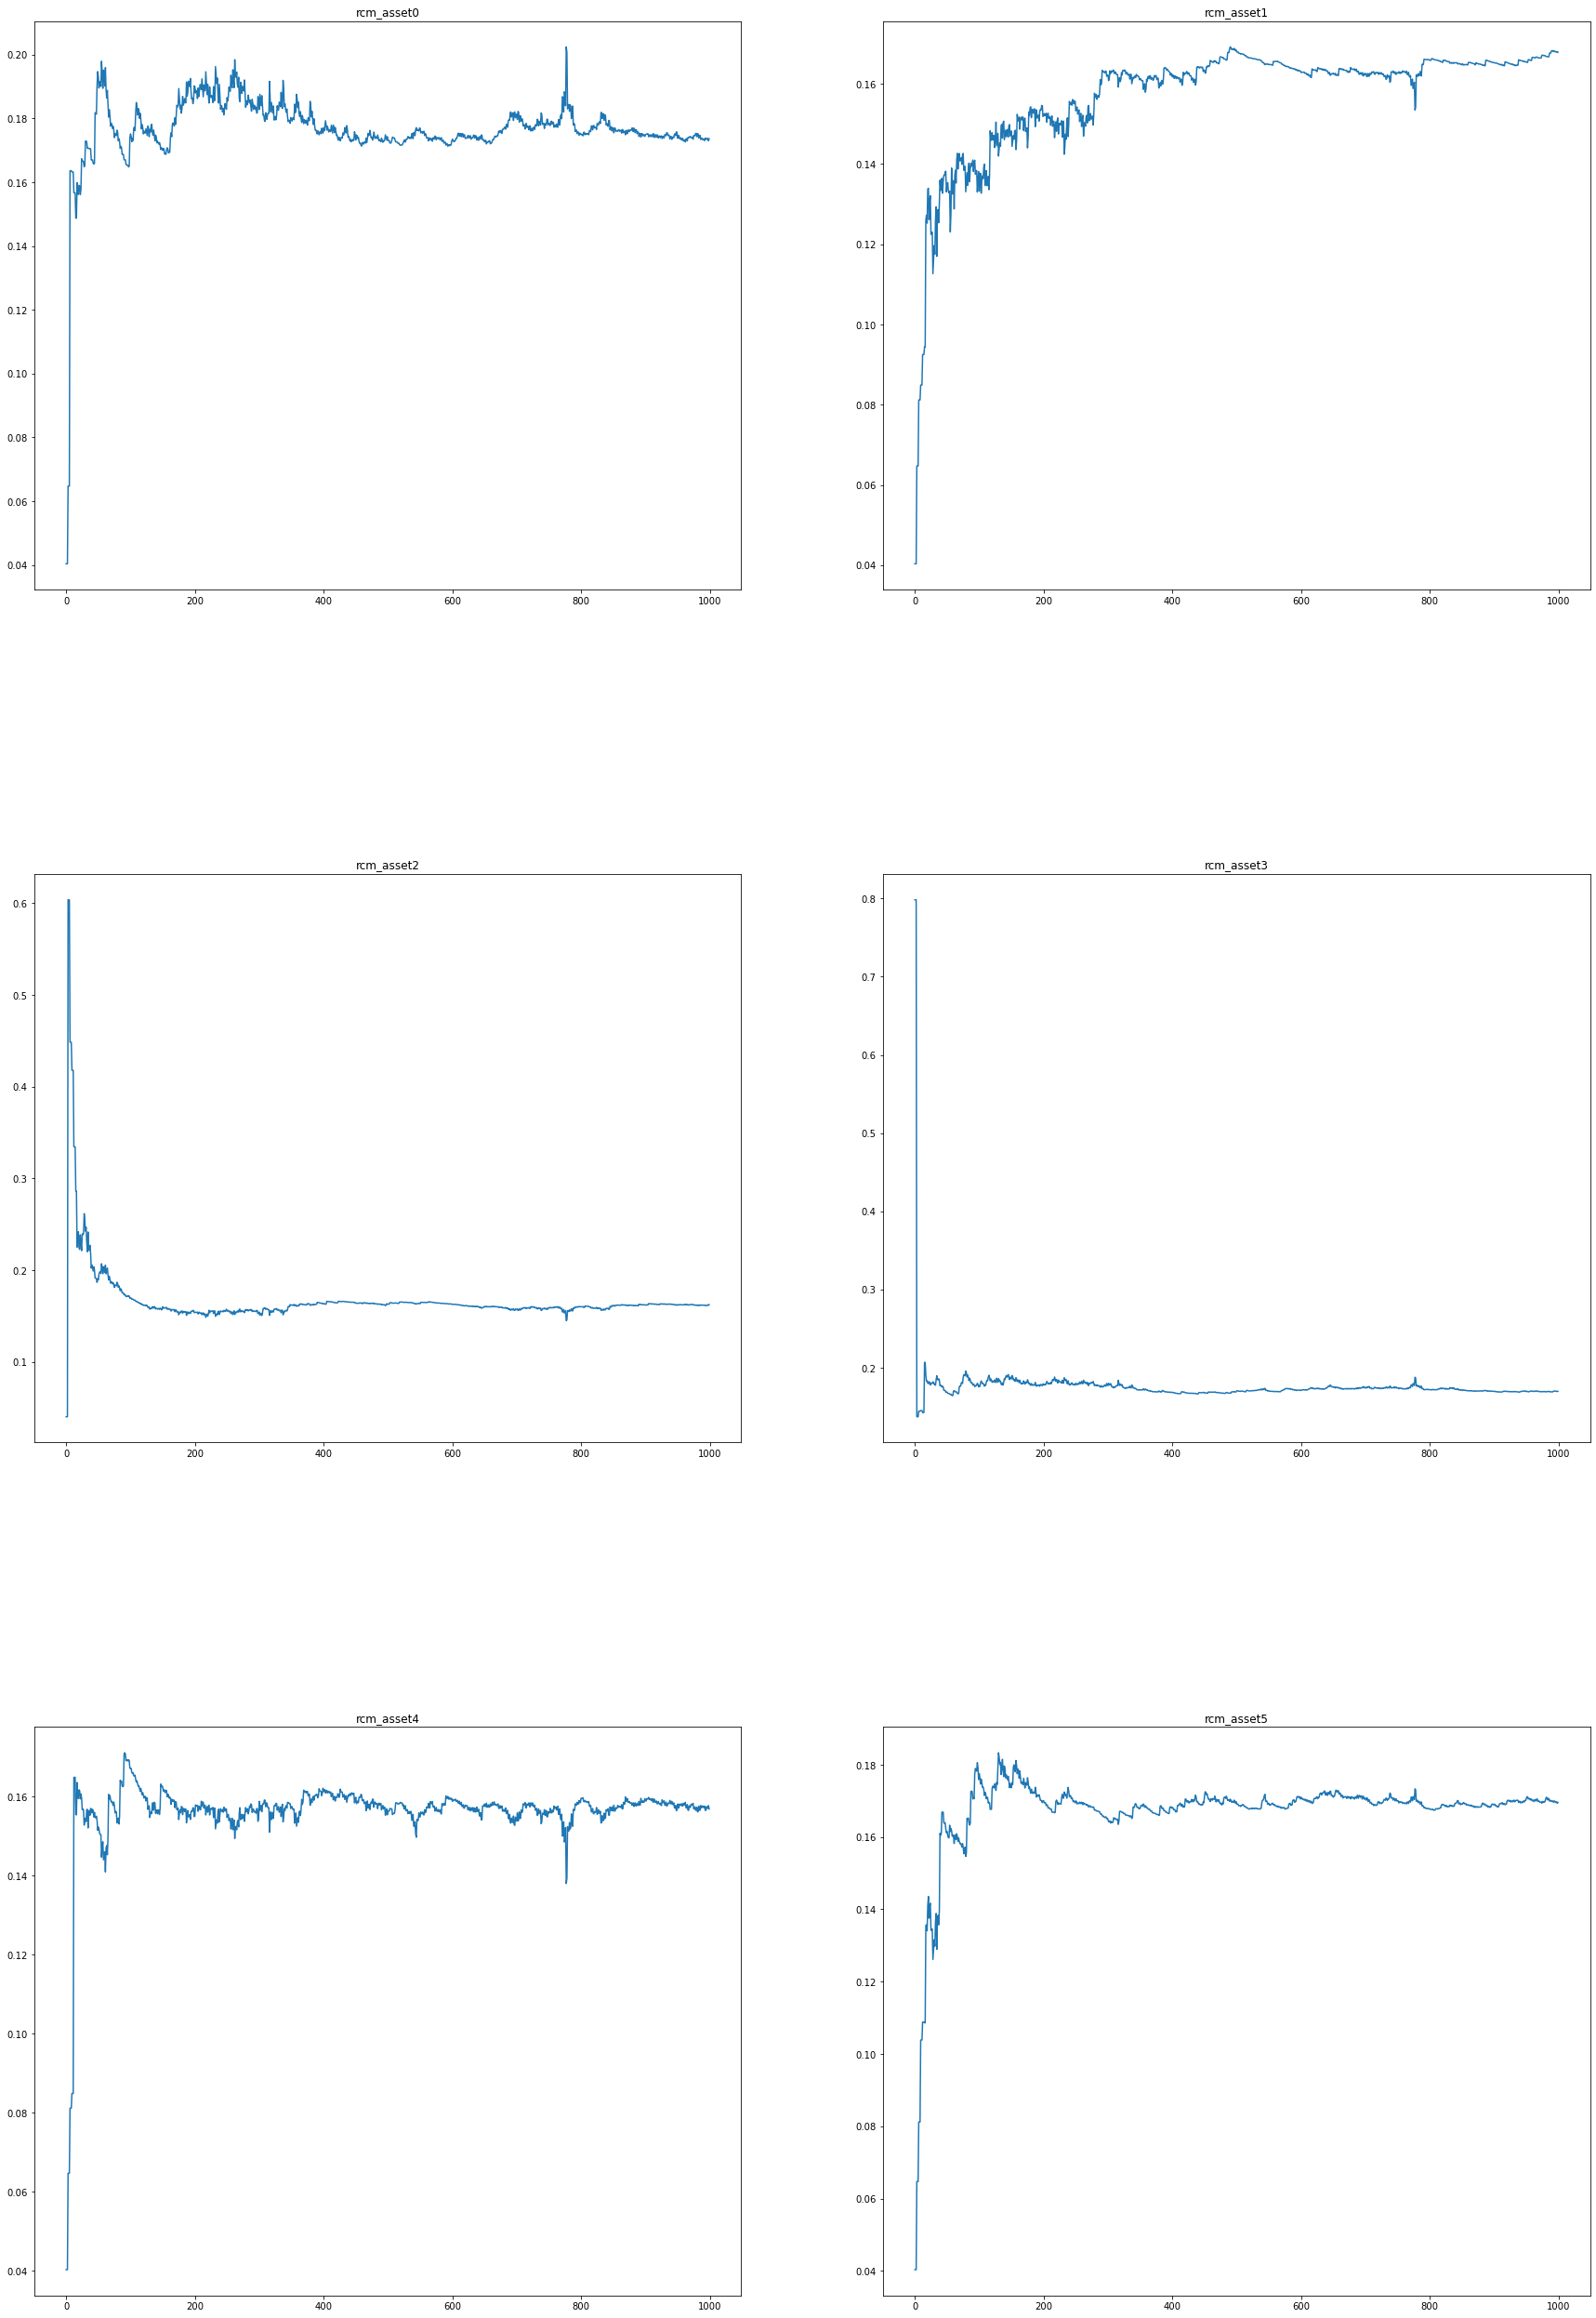

In [12]:
fig, axs = plt.subplots(3,2, figsize=(30, 45), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace= 0.2)

axs = axs.ravel()

for val, i in enumerate(df.columns):

    axs[val].plot(df[i])
    axs[val].set_title(i)